### Generate samples

In [20]:
from APES import *
from time import time
from matplotlib import font_manager
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
ticks_font = font_manager.FontProperties(family='helvetica-light-587ebe5a59211', style='normal',
    size=15, weight='normal', stretch='normal')
legend_font = font_manager.FontProperties(family='helvetica-light-587ebe5a59211', style='normal',
    size=12, weight='normal', stretch='normal')
hfont =  {'fontname':'helvetica-light-587ebe5a59211'}
csfont = {'fontname':'helvetica-light-587ebe5a59211'}
def calculate(val,index):
    mean = np.mean(val[:,index,:],axis=0)
    std = np.std(val[:,index,:],axis=0)
    return mean,std/np.sqrt(20)

In [9]:
def Get_dataset(Ego=False):
    if Ego:
        unique_count=26400
    else:
        unique_count=31200
    all_simu = np.load('in_out_{}_seq_EGO_{}.npz'.format(unique_count,Ego))

    data = all_simu['input_target']
    action_sequence = all_simu['action_sequence']

    if Ego:
        cnn_input = data[:,:693]
        rest_input = data[:,693:697]
        y = data[:,697]
        cnn_input = cnn_input.reshape((data.shape[0],11,21,3))
        rest_input = rest_input.reshape((data.shape[0],4))

        conv_size=(11,21,3,)
        rest_size=(4,)

    else:
        cnn_input = data[:,:676]
        rest_input = data[:,676:684]
        y = data[:,684]
        cnn_input = cnn_input.reshape((data.shape[0],13,13,4))
        rest_input = rest_input.reshape((data.shape[0],8))

        conv_size=(13,13,4,)
        rest_size=(8,)
    
    y = y.reshape((data.shape[0],1))
    naction =  Settings.PossibleActions.shape[0]
    return cnn_input,rest_input,y,conv_size,rest_size

### Ego actions are :0: Forward, 1:Backword, 2:Right, 3:left,4:nothing
### Allo actions are :0: North, 1:South, 2:West, 3:East, 4:nothing

## Allocentric decision test

In [10]:
cnn_input,rest_input,y,conv_size,rest_size = Get_dataset(Ego=False)
print(cnn_input.shape,rest_input.shape,y.shape)
print(conv_size,naction,rest_size)

(31200, 13, 13, 4) (31200, 8) (31200, 1)
(13, 13, 4) 5 (8,)


# Classifires

In [3]:
from keras.layers import Input,convolutional,Flatten,merge,Dense
from keras.models import load_model,Model
from APES import *
from time import time

def createLayers(insize,in_conv,naction):
    c = Input(shape=in_conv)
    con_process = c
    con_process = convolutional.Conv2D(filters=6,kernel_size=(3,3),activation="relu",padding="same",strides=1)(con_process)
    con_process = Flatten()(con_process)
    x = Input(shape=insize)#env.observation_space.shape)
    h = merge([con_process,x],mode="concat")
    h = Dense(32, activation='tanh')(h)
    h = Dense(32, activation='tanh')(h)
    z = Dense(1, activation='sigmoid')(h)
    return c,x, z

Using TensorFlow backend.
/gpfs/hpc/home/labash/miniconda3/envs/PT_old/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/gpfs/hpc/home/labash/miniconda3/envs/PT_old/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/gpfs/hpc/home/labash/miniconda3/envs/PT_old/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

### Classify Allocentric

In [6]:
num_exper= 20
epochs=20
info = np.zeros((num_exper,4,epochs))
for i in range(num_exper):
    c,x,z = createLayers(rest_size,conv_size,naction)

    allo_classifier = Model(inputs=[c,x],outputs=z)

    allo_classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    allo_classifier.summary()

    allo_history = allo_classifier.fit([cnn_input,rest_input],
                                       y,epochs=epochs,batch_size=64,validation_split=0.2)
    
    info[i,0,:] = allo_history.history['val_loss']
    info[i,1,:] = allo_history.history['val_acc']
    info[i,2,:] = allo_history.history['loss']
    info[i,3,:] = allo_history.history['acc']

/gpfs/hpc/home/labash/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if sys.path[0] == '':
/gpfs/hpc/home/labash/miniconda3/envs/PT_old/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 13, 13, 4)     0                                            
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 13, 13, 6)     222         input_3[0][0]                    
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 1014)          0           conv2d_2[0][0]                   
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 8)             0                                            
___________________________________________________________________________________________

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 5s - loss: 0.6815 - acc: 0.5813 - val_loss: 0.6780 - val_acc: 0.5806
Epoch 2/20
24960/24960 [==============================] - 4s - loss: 0.6601 - acc: 0.6047 - val_loss: 0.5841 - val_acc: 0.7478
Epoch 3/20
24960/24960 [==============================] - 4s - loss: 0.3230 - acc: 0.9017 - val_loss: 0.1485 - val_acc: 0.9803
Epoch 4/20
24960/24960 [==============================] - 3s - loss: 0.0857 - acc: 0.9933 - val_loss: 0.0527 - val_acc: 0.9981
Epoch 5/20
24960/24960 [==============================] - 3s - loss: 0.0332 - acc: 0.9998 - val_loss: 0.0236 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 3s - loss: 0.0160 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 3s - loss: 0.0089 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 3s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 4s - loss: 0.6815 - acc: 0.5792 - val_loss: 0.6799 - val_acc: 0.5806
Epoch 2/20
24960/24960 [==============================] - 3s - loss: 0.5353 - acc: 0.7453 - val_loss: 0.2874 - val_acc: 0.9345
Epoch 3/20
24960/24960 [==============================] - 3s - loss: 0.1686 - acc: 0.9729 - val_loss: 0.0998 - val_acc: 0.9899
Epoch 4/20
24960/24960 [==============================] - 3s - loss: 0.0634 - acc: 0.9951 - val_loss: 0.0437 - val_acc: 0.9982
Epoch 5/20
24960/24960 [==============================] - 3s - loss: 0.0270 - acc: 0.9998 - val_loss: 0.0190 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 4s - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 3s - loss: 0.0072 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 3s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 4s - loss: 0.6817 - acc: 0.5824 - val_loss: 0.6817 - val_acc: 0.5806
Epoch 2/20
24960/24960 [==============================] - 3s - loss: 0.6530 - acc: 0.6220 - val_loss: 0.5453 - val_acc: 0.7572
Epoch 3/20
24960/24960 [==============================] - 3s - loss: 0.3714 - acc: 0.8517 - val_loss: 0.2016 - val_acc: 0.9522
Epoch 4/20
24960/24960 [==============================] - 3s - loss: 0.1234 - acc: 0.9865 - val_loss: 0.0829 - val_acc: 0.9971
Epoch 5/20
24960/24960 [==============================] - 3s - loss: 0.0538 - acc: 0.9986 - val_loss: 0.0446 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 3s - loss: 0.0265 - acc: 0.9998 - val_loss: 0.0203 - val_acc: 0.9994
Epoch 7/20
24960/24960 [==============================] - 3s - loss: 0.0144 - acc: 1.0000 - val_loss: 0.0117 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 3s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 4s - loss: 0.6750 - acc: 0.5905 - val_loss: 0.6194 - val_acc: 0.6869
Epoch 2/20
24960/24960 [==============================] - 3s - loss: 0.5094 - acc: 0.7586 - val_loss: 0.3958 - val_acc: 0.8192
Epoch 3/20
24960/24960 [==============================] - 3s - loss: 0.2076 - acc: 0.9510 - val_loss: 0.1124 - val_acc: 0.9889
Epoch 4/20
24960/24960 [==============================] - 3s - loss: 0.0717 - acc: 0.9965 - val_loss: 0.0476 - val_acc: 0.9981
Epoch 5/20
24960/24960 [==============================] - 3s - loss: 0.0337 - acc: 0.9994 - val_loss: 0.0252 - val_acc: 0.9987
Epoch 6/20
24960/24960 [==============================] - 3s - loss: 0.0181 - acc: 0.9998 - val_loss: 0.0152 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 3s - loss: 0.0104 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 4s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 5s - loss: 0.6822 - acc: 0.5813 - val_loss: 0.6822 - val_acc: 0.5806
Epoch 2/20
24960/24960 [==============================] - 3s - loss: 0.6774 - acc: 0.5851 - val_loss: 0.6483 - val_acc: 0.6752
Epoch 3/20
24960/24960 [==============================] - 4s - loss: 0.4328 - acc: 0.8243 - val_loss: 0.2233 - val_acc: 0.9688
Epoch 4/20
24960/24960 [==============================] - 4s - loss: 0.1227 - acc: 0.9921 - val_loss: 0.0671 - val_acc: 1.0000
Epoch 5/20
24960/24960 [==============================] - 5s - loss: 0.0405 - acc: 0.9998 - val_loss: 0.0268 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 3s - loss: 0.0172 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 4s - loss: 0.0088 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 4s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 5s - loss: 0.6808 - acc: 0.5828 - val_loss: 0.6799 - val_acc: 0.5806
Epoch 2/20
24960/24960 [==============================] - 3s - loss: 0.6776 - acc: 0.5840 - val_loss: 0.6752 - val_acc: 0.5806
Epoch 3/20
24960/24960 [==============================] - 4s - loss: 0.6092 - acc: 0.6643 - val_loss: 0.5062 - val_acc: 0.7429
Epoch 4/20
24960/24960 [==============================] - 4s - loss: 0.4054 - acc: 0.8199 - val_loss: 0.2422 - val_acc: 0.9361
Epoch 5/20
24960/24960 [==============================] - 4s - loss: 0.1410 - acc: 0.9683 - val_loss: 0.0904 - val_acc: 0.9840
Epoch 6/20
24960/24960 [==============================] - 3s - loss: 0.0590 - acc: 0.9922 - val_loss: 0.0417 - val_acc: 0.9966
Epoch 7/20
24960/24960 [==============================] - 4s - loss: 0.0286 - acc: 0.9991 - val_loss: 0.0220 - val_acc: 0.9994
Epoch 8/20
24960/24960 [==============================] - 3s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 5s - loss: 0.6812 - acc: 0.5829 - val_loss: 0.6805 - val_acc: 0.5806
Epoch 2/20
24960/24960 [==============================] - 3s - loss: 0.6808 - acc: 0.5840 - val_loss: 0.6808 - val_acc: 0.5806
Epoch 3/20
24960/24960 [==============================] - 3s - loss: 0.6797 - acc: 0.5840 - val_loss: 0.6814 - val_acc: 0.5806
Epoch 4/20
24960/24960 [==============================] - 3s - loss: 0.6798 - acc: 0.5840 - val_loss: 0.6806 - val_acc: 0.5806
Epoch 5/20
24960/24960 [==============================] - 3s - loss: 0.6796 - acc: 0.5840 - val_loss: 0.6801 - val_acc: 0.5806
Epoch 6/20
24960/24960 [==============================] - 3s - loss: 0.6794 - acc: 0.5840 - val_loss: 0.6807 - val_acc: 0.5806
Epoch 7/20
24960/24960 [==============================] - 3s - loss: 0.6801 - acc: 0.5840 - val_loss: 0.6813 - val_acc: 0.5806
Epoch 8/20
24960/24960 [==============================] - 3s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 5s - loss: 0.6814 - acc: 0.5803 - val_loss: 0.6766 - val_acc: 0.5806
Epoch 2/20
24960/24960 [==============================] - 4s - loss: 0.4696 - acc: 0.7888 - val_loss: 0.2341 - val_acc: 0.9620
Epoch 3/20
24960/24960 [==============================] - 3s - loss: 0.1414 - acc: 0.9860 - val_loss: 0.0837 - val_acc: 0.9981
Epoch 4/20
24960/24960 [==============================] - 4s - loss: 0.0556 - acc: 0.9995 - val_loss: 0.0345 - val_acc: 1.0000
Epoch 5/20
24960/24960 [==============================] - 4s - loss: 0.0246 - acc: 1.0000 - val_loss: 0.0168 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 4s - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0092 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 4s - loss: 0.0069 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 4s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 5s - loss: 0.6771 - acc: 0.5818 - val_loss: 0.6389 - val_acc: 0.6595
Epoch 2/20
24960/24960 [==============================] - 4s - loss: 0.4825 - acc: 0.7621 - val_loss: 0.3488 - val_acc: 0.8804
Epoch 3/20
24960/24960 [==============================] - 3s - loss: 0.1958 - acc: 0.9541 - val_loss: 0.1060 - val_acc: 0.9904
Epoch 4/20
24960/24960 [==============================] - 4s - loss: 0.0603 - acc: 0.9981 - val_loss: 0.0386 - val_acc: 1.0000
Epoch 5/20
24960/24960 [==============================] - 4s - loss: 0.0226 - acc: 1.0000 - val_loss: 0.0158 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 3s - loss: 0.0105 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 3s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 3s -

### Ego centric decision

In [11]:
cnn_input,rest_input,y,conv_size,rest_size = Get_dataset(Ego=True)
print(cnn_input.shape,rest_input.shape,y.shape)
print(conv_size,naction,rest_size)

(26400, 11, 21, 3) (26400, 4) (26400, 1)
(11, 21, 3) 5 (4,)


In [13]:
ego_info = np.zeros((num_exper,4,epochs))
for i in range(num_exper):
    c,x,z = createLayers(rest_size,conv_size,naction)

    ego_classifier = Model(inputs=[c,x],outputs=z)

    ego_classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    ego_classifier.summary()

    ego_history = ego_classifier.fit([cnn_input,rest_input],
                                       y,epochs=epochs,batch_size=64,validation_split=0.2)
    
    ego_info[i,0,:] = ego_history.history['val_loss']
    ego_info[i,1,:] = ego_history.history['val_acc']
    ego_info[i,2,:] = ego_history.history['loss']
    ego_info[i,3,:] = ego_history.history['acc']

/gpfs/hpc/home/labash/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if sys.path[0] == '':
/gpfs/hpc/home/labash/miniconda3/envs/PT_old/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_45 (InputLayer)            (None, 11, 21, 3)     0                                            
____________________________________________________________________________________________________
conv2d_23 (Conv2D)               (None, 11, 21, 6)     168         input_45[0][0]                   
____________________________________________________________________________________________________
flatten_23 (Flatten)             (None, 1386)          0           conv2d_23[0][0]                  
____________________________________________________________________________________________________
input_46 (InputLayer)            (None, 4)             0                                            
___________________________________________________________________________________________

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 5s - loss: 0.6817 - acc: 0.5817 - val_loss: 0.6803 - val_acc: 0.5841
Epoch 2/20
21120/21120 [==============================] - 3s - loss: 0.6803 - acc: 0.5831 - val_loss: 0.6798 - val_acc: 0.5841
Epoch 3/20
21120/21120 [==============================] - 3s - loss: 0.6798 - acc: 0.5831 - val_loss: 0.6794 - val_acc: 0.5841
Epoch 4/20
21120/21120 [==============================] - 3s - loss: 0.6796 - acc: 0.5831 - val_loss: 0.6791 - val_acc: 0.5841
Epoch 5/20
21120/21120 [==============================] - 4s - loss: 0.6556 - acc: 0.6187 - val_loss: 0.5598 - val_acc: 0.7519
Epoch 6/20
21120/21120 [==============================] - 3s - loss: 0.4983 - acc: 0.7437 - val_loss: 0.4286 - val_acc: 0.7742
Epoch 7/20
21120/21120 [==============================] - 3s - loss: 0.4037 - acc: 0.7729 - val_loss: 0.3819 - val_acc: 0.7866
Epoch 8/20
21120/21120 [==============================] - 3s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 4s - loss: 0.6855 - acc: 0.5764 - val_loss: 0.6819 - val_acc: 0.5841
Epoch 2/20
21120/21120 [==============================] - 3s - loss: 0.6815 - acc: 0.5823 - val_loss: 0.6802 - val_acc: 0.5841
Epoch 3/20
21120/21120 [==============================] - 4s - loss: 0.6808 - acc: 0.5831 - val_loss: 0.6794 - val_acc: 0.5841
Epoch 4/20
21120/21120 [==============================] - 3s - loss: 0.6804 - acc: 0.5831 - val_loss: 0.6791 - val_acc: 0.5841
Epoch 5/20
21120/21120 [==============================] - 3s - loss: 0.6802 - acc: 0.5831 - val_loss: 0.6791 - val_acc: 0.5841
Epoch 6/20
21120/21120 [==============================] - 3s - loss: 0.6798 - acc: 0.5831 - val_loss: 0.6794 - val_acc: 0.5841
Epoch 7/20
21120/21120 [==============================] - 3s - loss: 0.6799 - acc: 0.5831 - val_loss: 0.6791 - val_acc: 0.5841
Epoch 8/20
21120/21120 [==============================] - 3s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 5s - loss: 0.6830 - acc: 0.5779 - val_loss: 0.6840 - val_acc: 0.5841
Epoch 2/20
21120/21120 [==============================] - 4s - loss: 0.6808 - acc: 0.5831 - val_loss: 0.6801 - val_acc: 0.5841
Epoch 3/20
21120/21120 [==============================] - 4s - loss: 0.6805 - acc: 0.5831 - val_loss: 0.6793 - val_acc: 0.5841
Epoch 4/20
21120/21120 [==============================] - 4s - loss: 0.6806 - acc: 0.5831 - val_loss: 0.6801 - val_acc: 0.5841
Epoch 5/20
21120/21120 [==============================] - 3s - loss: 0.6804 - acc: 0.5831 - val_loss: 0.6790 - val_acc: 0.5841
Epoch 6/20
21120/21120 [==============================] - 3s - loss: 0.6799 - acc: 0.5831 - val_loss: 0.6805 - val_acc: 0.5841
Epoch 7/20
21120/21120 [==============================] - 4s - loss: 0.6797 - acc: 0.5831 - val_loss: 0.6792 - val_acc: 0.5841
Epoch 8/20
21120/21120 [==============================] - 3s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 5s - loss: 0.6821 - acc: 0.5775 - val_loss: 0.6805 - val_acc: 0.5841
Epoch 2/20
21120/21120 [==============================] - 3s - loss: 0.6798 - acc: 0.5831 - val_loss: 0.6797 - val_acc: 0.5841
Epoch 3/20
21120/21120 [==============================] - 4s - loss: 0.6795 - acc: 0.5831 - val_loss: 0.6779 - val_acc: 0.5841
Epoch 4/20
21120/21120 [==============================] - 4s - loss: 0.6190 - acc: 0.6655 - val_loss: 0.5266 - val_acc: 0.7515
Epoch 5/20
21120/21120 [==============================] - 4s - loss: 0.4483 - acc: 0.7693 - val_loss: 0.3874 - val_acc: 0.7881
Epoch 6/20
21120/21120 [==============================] - 4s - loss: 0.3069 - acc: 0.8736 - val_loss: 0.2257 - val_acc: 0.9210
Epoch 7/20
21120/21120 [==============================] - 4s - loss: 0.1494 - acc: 0.9667 - val_loss: 0.0967 - val_acc: 0.9867
Epoch 8/20
21120/21120 [==============================] - 4s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 5s - loss: 0.6821 - acc: 0.5799 - val_loss: 0.6796 - val_acc: 0.5841
Epoch 2/20
21120/21120 [==============================] - 3s - loss: 0.6795 - acc: 0.5831 - val_loss: 0.6794 - val_acc: 0.5841
Epoch 3/20
21120/21120 [==============================] - 3s - loss: 0.6785 - acc: 0.5831 - val_loss: 0.6773 - val_acc: 0.5841
Epoch 4/20
21120/21120 [==============================] - 3s - loss: 0.6729 - acc: 0.5831 - val_loss: 0.6741 - val_acc: 0.5841
Epoch 5/20
21120/21120 [==============================] - 3s - loss: 0.6684 - acc: 0.5812 - val_loss: 0.6760 - val_acc: 0.5841
Epoch 6/20
21120/21120 [==============================] - 3s - loss: 0.6657 - acc: 0.5806 - val_loss: 0.6725 - val_acc: 0.5841
Epoch 7/20
21120/21120 [==============================] - 3s - loss: 0.6642 - acc: 0.5798 - val_loss: 0.6734 - val_acc: 0.5841
Epoch 8/20
21120/21120 [==============================] - 4s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 5s - loss: 0.6828 - acc: 0.5789 - val_loss: 0.6809 - val_acc: 0.5841
Epoch 2/20
21120/21120 [==============================] - 4s - loss: 0.6808 - acc: 0.5831 - val_loss: 0.6809 - val_acc: 0.5841
Epoch 3/20
21120/21120 [==============================] - 4s - loss: 0.6798 - acc: 0.5831 - val_loss: 0.6799 - val_acc: 0.5841
Epoch 4/20
21120/21120 [==============================] - 4s - loss: 0.6771 - acc: 0.5837 - val_loss: 0.6594 - val_acc: 0.5987
Epoch 5/20
21120/21120 [==============================] - 4s - loss: 0.5709 - acc: 0.7064 - val_loss: 0.4957 - val_acc: 0.7339
Epoch 6/20
21120/21120 [==============================] - 4s - loss: 0.4333 - acc: 0.7652 - val_loss: 0.3965 - val_acc: 0.7816
Epoch 7/20
21120/21120 [==============================] - 4s - loss: 0.3779 - acc: 0.7816 - val_loss: 0.3624 - val_acc: 0.7877
Epoch 8/20
21120/21120 [==============================] - 3s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 5s - loss: 0.6818 - acc: 0.5823 - val_loss: 0.6799 - val_acc: 0.5841
Epoch 2/20
21120/21120 [==============================] - 3s - loss: 0.6800 - acc: 0.5831 - val_loss: 0.6793 - val_acc: 0.5841
Epoch 3/20
21120/21120 [==============================] - 4s - loss: 0.6794 - acc: 0.5831 - val_loss: 0.6794 - val_acc: 0.5841
Epoch 4/20
21120/21120 [==============================] - 4s - loss: 0.6795 - acc: 0.5831 - val_loss: 0.6791 - val_acc: 0.5841
Epoch 5/20
21120/21120 [==============================] - 4s - loss: 0.6791 - acc: 0.5831 - val_loss: 0.6786 - val_acc: 0.5841
Epoch 6/20
21120/21120 [==============================] - 3s - loss: 0.6766 - acc: 0.5831 - val_loss: 0.6754 - val_acc: 0.5841
Epoch 7/20
21120/21120 [==============================] - 3s - loss: 0.6707 - acc: 0.5815 - val_loss: 0.6740 - val_acc: 0.5841
Epoch 8/20
21120/21120 [==============================] - 3s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 5s - loss: 0.6825 - acc: 0.5808 - val_loss: 0.6801 - val_acc: 0.5841
Epoch 2/20
21120/21120 [==============================] - 4s - loss: 0.6802 - acc: 0.5831 - val_loss: 0.6788 - val_acc: 0.5841
Epoch 3/20
21120/21120 [==============================] - 4s - loss: 0.6144 - acc: 0.6624 - val_loss: 0.4902 - val_acc: 0.7534
Epoch 4/20
21120/21120 [==============================] - 4s - loss: 0.4182 - acc: 0.7807 - val_loss: 0.3723 - val_acc: 0.8121
Epoch 5/20
21120/21120 [==============================] - 3s - loss: 0.3483 - acc: 0.8327 - val_loss: 0.2982 - val_acc: 0.8771
Epoch 6/20
21120/21120 [==============================] - 4s - loss: 0.2234 - acc: 0.9181 - val_loss: 0.1543 - val_acc: 0.9581
Epoch 7/20
21120/21120 [==============================] - 4s - loss: 0.1143 - acc: 0.9731 - val_loss: 0.0795 - val_acc: 0.9920
Epoch 8/20
21120/21120 [==============================] - 4s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 5s - loss: 0.6820 - acc: 0.5808 - val_loss: 0.6799 - val_acc: 0.5841
Epoch 2/20
21120/21120 [==============================] - 3s - loss: 0.6796 - acc: 0.5831 - val_loss: 0.6799 - val_acc: 0.5841
Epoch 3/20
21120/21120 [==============================] - 3s - loss: 0.6678 - acc: 0.5992 - val_loss: 0.5929 - val_acc: 0.7364
Epoch 4/20
21120/21120 [==============================] - 3s - loss: 0.4781 - acc: 0.7588 - val_loss: 0.3897 - val_acc: 0.7985
Epoch 5/20
21120/21120 [==============================] - 3s - loss: 0.3720 - acc: 0.7938 - val_loss: 0.3546 - val_acc: 0.8172
Epoch 6/20
21120/21120 [==============================] - 3s - loss: 0.3223 - acc: 0.8420 - val_loss: 0.2797 - val_acc: 0.8735
Epoch 7/20
21120/21120 [==============================] - 4s - loss: 0.2169 - acc: 0.9189 - val_loss: 0.1624 - val_acc: 0.9536
Epoch 8/20
21120/21120 [==============================] - 4s -

In [14]:
y.shape

(26400, 1)

In [15]:
np.savez('val_train_acc_loss_E.npz',allo=info,ego=ego_info)

### Plot

In [16]:
from APES import *
from time import time
from matplotlib import font_manager
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
ticks_font = font_manager.FontProperties(family='helvetica-light-587ebe5a59211', style='normal',
    size=15, weight='normal', stretch='normal')
legend_font = font_manager.FontProperties(family='helvetica-light-587ebe5a59211', style='normal',
    size=12, weight='normal', stretch='normal')
hfont =  {'fontname':'helvetica-light-587ebe5a59211'}
csfont = {'fontname':'helvetica-light-587ebe5a59211'}
def calculate(val,index):
    mean = np.mean(val[:,index,:],axis=0)
    std = np.std(val[:,index,:],axis=0)
    return mean,std/np.sqrt(20)

In [17]:
info = np.load('val_train_acc_loss_E.npz')
ego_info = info['ego']
info = info['allo']

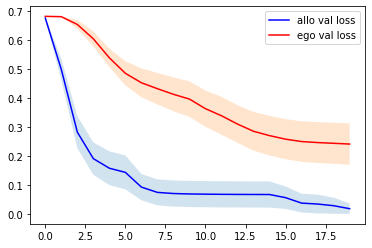

In [18]:
avlm,avls = calculate(info,0)
evlm,evls = calculate(ego_info,0)
plt.plot(avlm,color='b',label='allo val loss')
plt.fill_between(np.arange(20),avlm+avls,avlm-avls,alpha=0.2)

plt.plot(evlm,color='r',label='ego val loss')
plt.fill_between(np.arange(20),evlm+evls,evlm-evls,alpha=0.2)
#plt.ylabel('loss')
#plt.xlabel('Epoch')
plt.legend()

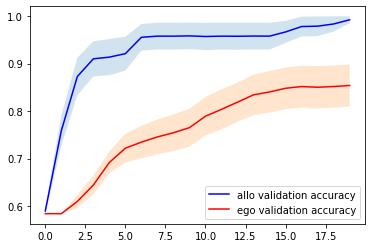

In [19]:
avam,avas = calculate(info,1)
evam,evas = calculate(ego_info,1)
plt.plot(avam,color='b',label='allo validation accuracy')
plt.fill_between(np.arange(20),avam+avas,avam-avas,alpha=0.2)
plt.plot(evam,color='r',label='ego validation accuracy')
plt.fill_between(np.arange(20),evam+evas,evam-evas,alpha=0.2)
atam,avas = calculate(info,3)
etam,evas = calculate(ego_info,3)
#plt.plot(atam,color='black',label='allo training accuracy')

#plt.plot(etam,color='r',label='ego training accuracy')

plt.legend()